In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import dgl
import torch
import os

from pyGAT.model import *
from utils import *

Using backend: pytorch


# Experiment

In [43]:
def run(struct, size, epochs, training_size=None):
    # make sure to generate before running an experiment
    path_to_train = "./pgm_graph_inference/graphical_models/datasets/train/"
    path_to_test = "./pgm_graph_inference/graphical_models/datasets/test/"
    path_to_train = os.path.join(path_to_train, struct, str(size))
    path_to_test = os.path.join(path_to_test, struct, str(size))
    train_adjs, train_margs = get_data_set(path_to_train)
    test_adjs, test_margs = get_data_set(path_to_test)

    # randomize training data
    train_idx = list(range(train_adjs.shape[0]))
    np.random.shuffle(train_idx)

    if training_size != None:
        train_idx = train_idx[0:training_size]

    n = size
    # change according to graph structure
    if struct == 'wheel':
        nx_g = nx.wheel_graph(n)
    else:
        nx_g = nx.path_graph(n)
    g = dgl.from_networkx(nx_g)
    nodes = g.num_nodes()
    model = GAT(g, in_dim = nodes, hidden_dim=200, out_dim=2, num_heads=3)

    num_graphs = len(train_idx)
    m = nn.Softmax(dim=1)
    optimizer = torch.optim.AdamW(model.parameters())
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, total_steps=epochs * num_graphs, max_lr = 1e-2 / num_graphs)
    step = 0

    acc_list = []
    err_list = []
    for epoch in range(epochs):
        losses = []
        for i in range(num_graphs):
            logits = m(model(train_adjs[train_idx[i]]))
            loss = F.binary_cross_entropy(logits, train_margs[train_idx[i]])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss)
            scheduler.step(step)
            step += 1
        epoch_loss = torch.stack(losses).mean()
        #optimizer.zero_grad()
        #epoch_loss.backward()
        #optimizer.step()
        #scheduler.step(epoch)

        train_accs = []
        train_errs = []
        for i in range(num_graphs):
            pred = m(model(train_adjs[train_idx[i]]))
            err = evaluate_error(pred.detach().numpy(), train_margs[train_idx[i]].detach().numpy())
            acc = evaluate_map_acc(pred.detach().numpy(), train_margs[train_idx[i]].detach().numpy())
            train_errs.append(err)
            train_accs.append(acc)

        test_errs = []
        test_accs = []
        for i in range(test_adjs.size()[0]):
            pred = m(model(test_adjs[i]))
            err = evaluate_error(pred.detach().numpy(), test_margs[i].detach().numpy())
            acc = evaluate_map_acc(pred.detach().numpy(), test_margs[i].detach().numpy())
            test_errs.append(err)
            test_accs.append(acc)
        print('Epoch: %d LR: %.4f Loss: %.4f Train Acc: %.4f Train Err: %.4f Test Acc: %.4f Test Err %.4f' % (
                epoch,
                optimizer.param_groups[0]['lr'],
                epoch_loss.item(),
                np.mean(train_accs),
                np.mean(train_errs),
                np.mean(test_accs),
                np.mean(test_errs),
            ))
        acc_list.append(np.mean(test_accs))
        err_list.append(np.mean(test_errs))
    
    pred_margs = []
    for i in range(test_adjs.size()[0]):
        pred = m(model(test_adjs[i]))
        pred_margs.append(pred)

    results = {}
    results['acc_list'] = acc_list
    results['err_list'] = err_list
    results['pred_margs'] = pred_margs
    results['test_margs'] = test_margs
    return results

In [ ]:
path_9_50 = run('path', 9, 10, 50)
path_9_100 = run('path', 9, 10, 100)
path_9_1000 = run('path', 9, 10, 1000)

x = list(range(1,11))
plt.plot(x, path_9_50['acc_list'], label='50')
plt.plot(x, path_9_100['acc_list'], label='100')
plt.plot(x, path_9_1000['acc_list'], label='1000')
plt.legend()
plt.title('MAP Accuracy')
plt.show()
plt.plot(x, path_9_50['err_list'], label='50')
plt.plot(x, path_9_100['err_list'], label='100')
plt.plot(x, path_9_1000['err_list'], label='1000')
plt.legend()
plt.title('Error')
plt.show()

In [44]:
path_9 = run('path', 9, 10)
path_30 = run('path', 30, 10)
path_100 = run('path', 100, 10)
wheel_9 = run('wheel', 9, 10)

C:\Users\jhuan\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 LR: 0.0000 Loss: 0.7147 Train Acc: 0.5122 Train Err: 0.2968 Test Acc: 0.5221 Test Err 0.2939
Epoch: 1 LR: 0.0000 Loss: 0.6933 Train Acc: 0.5850 Train Err: 0.2786 Test Acc: 0.5814 Test Err 0.2743
Epoch: 2 LR: 0.0000 Loss: 0.6611 Train Acc: 0.6638 Train Err: 0.2592 Test Acc: 0.6645 Test Err 0.2533
Epoch: 3 LR: 0.0000 Loss: 0.6422 Train Acc: 0.6734 Train Err: 0.2489 Test Acc: 0.6834 Test Err 0.2422
Epoch: 4 LR: 0.0000 Loss: 0.6359 Train Acc: 0.6737 Train Err: 0.2446 Test Acc: 0.6845 Test Err 0.2377
Epoch: 5 LR: 0.0000 Loss: 0.6340 Train Acc: 0.6734 Train Err: 0.2427 Test Acc: 0.6845 Test Err 0.2357
Epoch: 6 LR: 0.0000 Loss: 0.6333 Train Acc: 0.6736 Train Err: 0.2419 Test Acc: 0.6855 Test Err 0.2348
Epoch: 7 LR: 0.0000 Loss: 0.6330 Train Acc: 0.6737 Train Err: 0.2415 Test Acc: 0.6861 Test Err 0.2344
Epoch: 8 LR: 0.0000 Loss: 0.6329 Train Acc: 0.6734 Train Err: 0.2414 Test Acc: 0.6861 Test Err 0.2343
Epoch: 9 LR: 0.0000 Loss: 0.6328 Train Acc: 0.6734 Train Err: 0.2414 Test Acc: 0.6

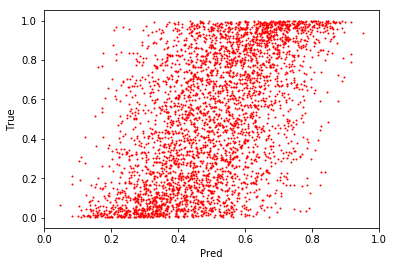

In [55]:
pred = path_9['pred_margs']
true = path_9['test_margs']

for i in range(len(pred)):
    plt.scatter(pred[i].detach().numpy(), true[i].detach().numpy(), c='red', s=1)
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

pred = path_100['pred_margs']
true = path_100['test_margs']

for i in range(len(pred)):
    plt.scatter(pred[i].detach().numpy(), true[i].detach().numpy(), c='red', s=0.01)
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()